In [1]:
# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# import libraries


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import os
import sklearn.preprocessing


from sklearn.model_selection import train_test_split

# wrangle
import wrangle
import env

### Acquire Data
- Built functions for acquiring data from codeup database ultimately stored in my wrangle.py file.

In [2]:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    '''
    Function allows user to access Codeup database using their own 
    credentials stored in  their env.py file
    '''
    
# Returns with correct address/password combinat to access the database
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [3]:
def new_zillow_data():
    '''
    SQL query that joins three other tables to properties_2017
    '''
    
    sql_query = '''
                SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, lotsizesquarefeet, taxvaluedollarcnt, yearbuilt, fips FROM properties_2017
                right join predictions_2017 using (parcelid)
                join propertylandusetype using (propertylandusetypeid)
                where propertylandusedesc = "Single Family Residential"
                '''
    
# Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
# Returns the called dataframe
    return df

In [4]:
def get_zillow_data():
    '''
    Function allows user to access zillow_data from Codeup database and write it\n
    to a csv file then returns the dataframe.
    '''
    
# if statement that checks if there's already a .csv file to use 
    if os.path.isfile('zillow.csv'):
        
# If csv file exists read in data from csv file.
        df = pd.read_csv('zillow.csv', index_col=0)
        
# Alternative if no csv file found then
    else:
        
# Read fresh data from db into a DataFrame
        df = new_zillow_data()
        
# Cache data for local use
        df.to_csv('zillow.csv')

# Returns requested df
    return df

In [5]:
zillow_df = get_zillow_data()
zillow_df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,yearbuilt,fips
0,4.0,2.5,2490.0,8580.0,691000.0,1969.0,6059.0
1,4.0,2.0,1808.0,86392.0,241131.0,1980.0,6037.0
2,4.0,2.0,1878.0,11078.0,94598.0,1965.0,6037.0
3,4.0,2.0,1207.0,7200.0,380736.0,1964.0,6059.0
4,2.0,1.0,728.0,5294.0,33497.0,1925.0,6037.0


In [6]:
zillow_df.shape

(52442, 7)

In [7]:
zillow_df.info

<bound method DataFrame.info of        bedroomcnt  bathroomcnt  calculatedfinishedsquarefeet  \
0             4.0          2.5                        2490.0   
1             4.0          2.0                        1808.0   
2             4.0          2.0                        1878.0   
3             4.0          2.0                        1207.0   
4             2.0          1.0                         728.0   
...           ...          ...                           ...   
52437         2.0          1.0                         855.0   
52438         2.0          1.0                         714.0   
52439         3.0          2.0                        1494.0   
52440         3.0          2.0                        1310.0   
52441         3.0          2.0                        1280.0   

       lotsizesquarefeet  taxvaluedollarcnt  yearbuilt    fips  
0                 8580.0           691000.0     1969.0  6059.0  
1                86392.0           241131.0     1980.0  6037.0  
2   

In [8]:
zillow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,52442.0,3.300675,0.949086,0.0,3.0,3.0,4.0,14.0
bathroomcnt,52442.0,2.299397,1.022764,0.0,2.0,2.0,3.0,18.0
calculatedfinishedsquarefeet,52360.0,1922.874083,1004.363491,128.0,1268.0,1659.0,2306.0,21929.0
lotsizesquarefeet,52073.0,11339.520135,86746.804342,236.0,5583.0,6840.0,8798.0,6971010.0
taxvaluedollarcnt,52441.0,529683.008524,751888.311091,1000.0,193750.0,373612.0,619301.0,49061236.0
yearbuilt,52326.0,1963.393820,23.133355,1878.0,1950.0,1961.0,1979.0,2016.0
fips,52442.0,6049.131917,21.028933,6037.0,6037.0,6037.0,6059.0,6111.0


### Prepare Data
- Built functions for preparing data zillow dataframe ultimately stored in my wrangle.py file.

In [9]:
# checks for any null values, which are shown below.
pd.isnull(zillow_df).sum()

bedroomcnt                        0
bathroomcnt                       0
calculatedfinishedsquarefeet     82
lotsizesquarefeet               369
taxvaluedollarcnt                 1
yearbuilt                       116
fips                              0
dtype: int64

In [10]:
# shows relative proportion of nulls in each column vs entire df
zillow_df.isna().mean()

bedroomcnt                      0.000000
bathroomcnt                     0.000000
calculatedfinishedsquarefeet    0.001564
lotsizesquarefeet               0.007036
taxvaluedollarcnt               0.000019
yearbuilt                       0.002212
fips                            0.000000
dtype: float64

In [11]:
# shows percentage of data left if we dropped all rows with any null values
round(zillow_df.dropna().shape[0] / zillow_df.shape[0], 4)

0.9908

In [12]:
# drops the rows with any null values and returns a new null-free df
zillow_df = zillow_df.dropna()

In [13]:
zillow_df.isna().mean()

bedroomcnt                      0.0
bathroomcnt                     0.0
calculatedfinishedsquarefeet    0.0
lotsizesquarefeet               0.0
taxvaluedollarcnt               0.0
yearbuilt                       0.0
fips                            0.0
dtype: float64

In [14]:
def handle_nulls(df):
    '''
    Gets rid of the rows with any null values and returns a new null-free df
    '''
    
# drops the rows with any null values and returns a new null-free df
    df = df.dropna()
    
    
    return df

In [15]:
zillow_df['fips'].value_counts()

6037.0    33568
6059.0    14034
6111.0     4358
Name: fips, dtype: int64

In [16]:
zillow_df['county'] = zillow_df['fips'].astype(str)
zillow_df['county']

0        6059.0
1        6037.0
2        6037.0
3        6059.0
4        6037.0
          ...  
52437    6111.0
52438    6037.0
52439    6037.0
52440    6111.0
52441    6037.0
Name: county, Length: 51960, dtype: object

In [17]:
zillow_df['county'].value_counts()

6037.0    33568
6059.0    14034
6111.0     4358
Name: county, dtype: int64

In [18]:
zillow_df['county'] = zillow_df['county'].replace(['6037.0', '6059.0', '6111.0'], ['Los Angeles', 'Orange', 'Ventura'])

In [19]:
def num_distribution(df):
    for col in df.columns:
        if df[col].dtype != 'object':
            plt.hist(df[col])
            plt.title(f'Distribution of {col}')
            plt.show()

In [20]:
zillow_df

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,yearbuilt,fips,county
0,4.0,2.5,2490.0,8580.0,691000.0,1969.0,6059.0,Orange
1,4.0,2.0,1808.0,86392.0,241131.0,1980.0,6037.0,Los Angeles
2,4.0,2.0,1878.0,11078.0,94598.0,1965.0,6037.0,Los Angeles
3,4.0,2.0,1207.0,7200.0,380736.0,1964.0,6059.0,Orange
4,2.0,1.0,728.0,5294.0,33497.0,1925.0,6037.0,Los Angeles
...,...,...,...,...,...,...,...,...
52437,2.0,1.0,855.0,3000.0,112526.0,1979.0,6111.0,Ventura
52438,2.0,1.0,714.0,7980.0,147864.0,1949.0,6037.0,Los Angeles
52439,3.0,2.0,1494.0,8148.0,150472.0,1991.0,6037.0,Los Angeles
52440,3.0,2.0,1310.0,5631.0,446000.0,1969.0,6111.0,Ventura


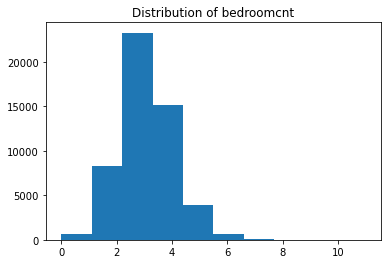

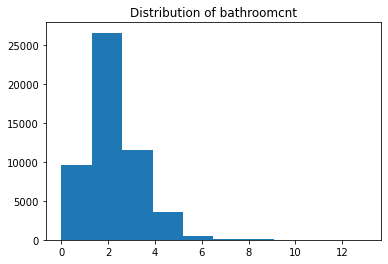

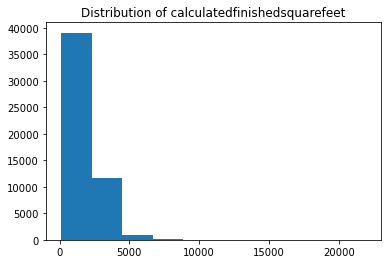

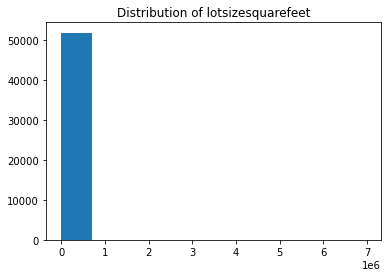

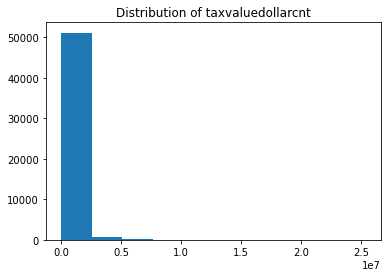

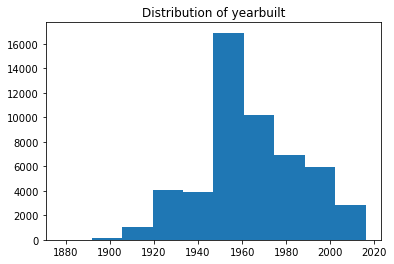

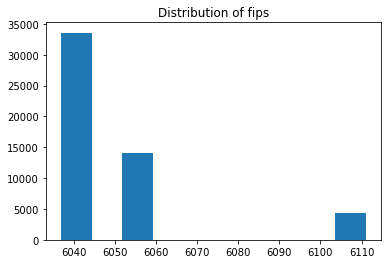

In [21]:
num_distribution(zillow_df)

In [22]:
# We can use the following code to figure out that 100% of calculatedfinishedsquarefeet can be converted to int w/o data loss
(zillow_df.calculatedfinishedsquarefeet == zillow_df.calculatedfinishedsquarefeet.astype(int)).mean()

1.0

In [23]:
# Same with taxvaluedollarcnt. 100% of taxvaluedollarcnt can lose the deicimal and be OK
(zillow_df.taxvaluedollarcnt == zillow_df.taxvaluedollarcnt.astype(int)).mean()

1.0

In [24]:
# This is not the case for out bathrooms
(zillow_df.bathroomcnt == zillow_df.bathroomcnt.astype(int)).mean()

0.8721324095458045

In [68]:
# But is also the case for our bedrooms
(zillow_df.bedroomcnt == zillow_df.bedroomcnt.astype(int)).mean()

1.0

In [26]:
# And is also the case for the square feet for our lot sizes
(zillow_df.lotsizesquarefeet == zillow_df.lotsizesquarefeet.astype(int)).mean()

1.0

In [27]:
def float_to_int(df):
    '''
    Converts our fips, bedrooms, calculatedfinishedsquarefeet, lotsizesquarefeet, taxvaluedollarcnt, and yearbuilt from floats to integers
    '''
# converts our fips, bedrooms, calculatedfinishedsquarefeet, taxvaluedollarcnt, and yearbuilt from floats to integers
    df["fips"] = df["fips"].astype(int)
    df["yearbuilt"] = df["yearbuilt"].astype(int)
    df["bedroomcnt"] = df["bedroomcnt"].astype(int)
    df["taxvaluedollarcnt"] = df["taxvaluedollarcnt"].astype(int)
    df["calculatedfinishedsquarefeet"] = df["calculatedfinishedsquarefeet"].astype(int)
    df["lotsizesquarefeet"] = df["lotsizesquarefeet"].astype(int)
    
    return df

In [28]:
def clean_zillow(df):
    '''
    Groups our functions used to clean up our data into a single function for ease of use
    '''
    
    df = handle_nulls(df)
    df = float_to_int(df)
    
    return df

In [29]:
def split_zillow(df):
    '''
    Takes our df and splits it into train, validate, and test dfs for exploration, fitting, validation, and testing
    '''
    
# splits the full data set 80/20 into train and test dataframes stratified 
# around taxvaluedollarcnt, the target variable, using the train_test_split function
    train, test = train_test_split(df, 
                               train_size = 0.80, 
                               stratify = df.fips, 
                               random_state=2468)

# splits the train dataframe 60/40 into the new train and validate dataframes
# they're stratified around taxvaluedollarcnt again using the train_test_split function
    train, validate = train_test_split(train,
                                    train_size = 0.60,
                                    stratify = train.fips,
                                    random_state=2468)
    
# returns the three dataframes we'll use for training, validation, and testing
    return train, validate, test

In [30]:
train, validate, test = split_zillow(zillow_df)


In [31]:
print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (24940, 8)
validate -> (16628, 8)
test -> (10392, 8)


In [32]:
# splits our training set into x and y values to run in our algorithms
X_train = train.drop(columns=['taxvaluedollarcnt'])
y_train = train['taxvaluedollarcnt']

# splits our validate set into x and y values to run in our algorithms
X_validate = validate.drop(columns=['taxvaluedollarcnt'])
y_validate = validate['taxvaluedollarcnt']

# splits our test set into x and y values to run in our algorithms
X_test = test.drop(columns=['taxvaluedollarcnt'])
y_test = test['taxvaluedollarcnt']

### Wrangle Data
- Acquire and Prepare Data functions all combined into a single wrangle function

In [33]:
def wrangle_zillow():
    '''
    Function that acquires zillow data using the new_zillow_data function and 
    caches it, as a csv file, if there isn't already a local copy, then cleans
    and splits the data into train, test, and validate
    '''
    df = get_zillow_data()
    df = clean_zillow(df)
    train, validate, test = split_zillow(df)
    
    return train, validate, test


### Explore Data

In [34]:
plt.rc('font', size=14)
plt.rc('figure', figsize=(14, 10))

alpha = .05

In [35]:
explore_train = train[['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet',
       'taxvaluedollarcnt',	'yearbuilt', 'county']]

In [36]:
melted = explore_train.melt(id_vars=['county'])

In [37]:
melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149640 entries, 0 to 149639
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   county    149640 non-null  object 
 1   variable  149640 non-null  object 
 2   value     149640 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.4+ MB


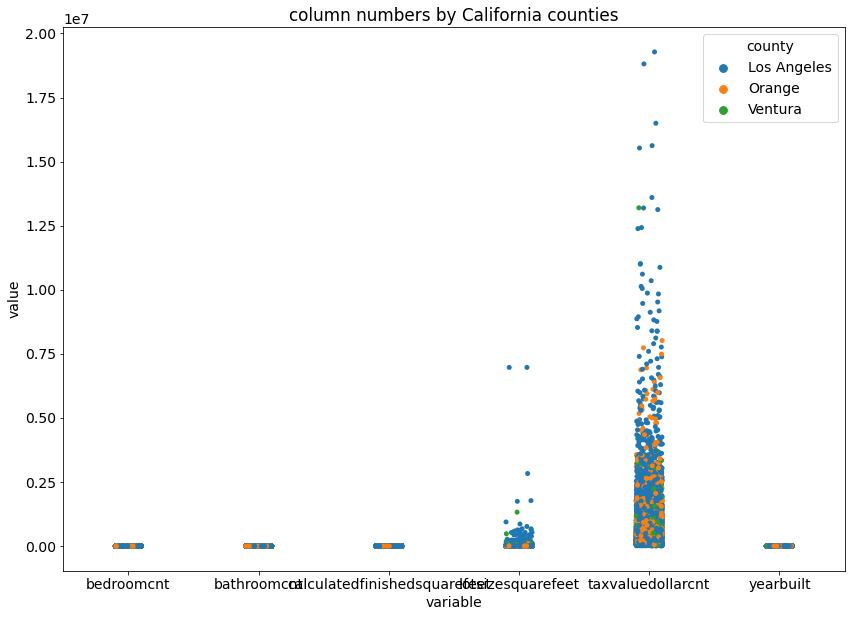

In [38]:
# fips = county code
sns.stripplot(data=melted, x='variable', y='value', hue='county')

plt.title('column numbers by California counties')

plt.show()

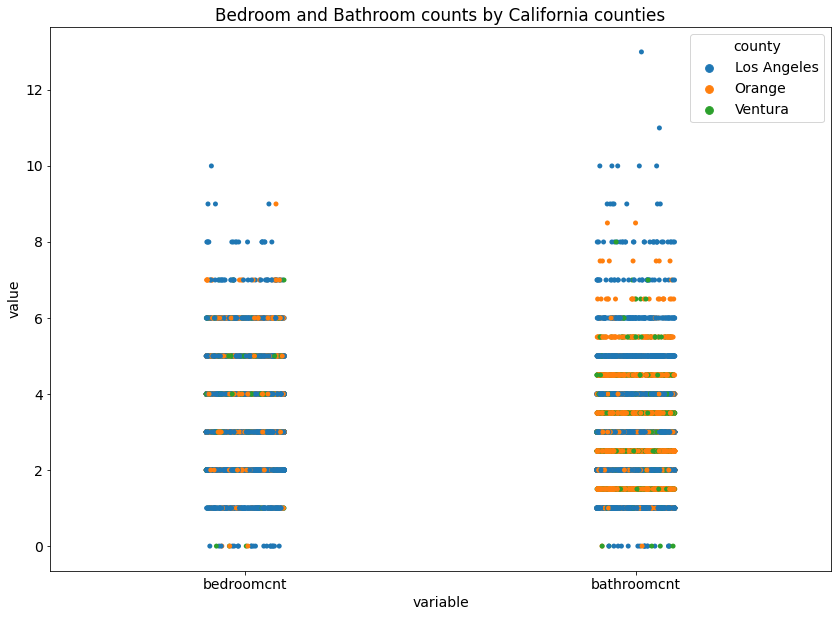

In [69]:
explore_train1 = train[['bedroomcnt', 'bathroomcnt', 'county']]

melted = explore_train1.melt(id_vars=['county'])

sns.stripplot(data=melted, x='variable', y='value', hue='county')

plt.title('Bedroom and Bathroom counts by California counties')

plt.show()

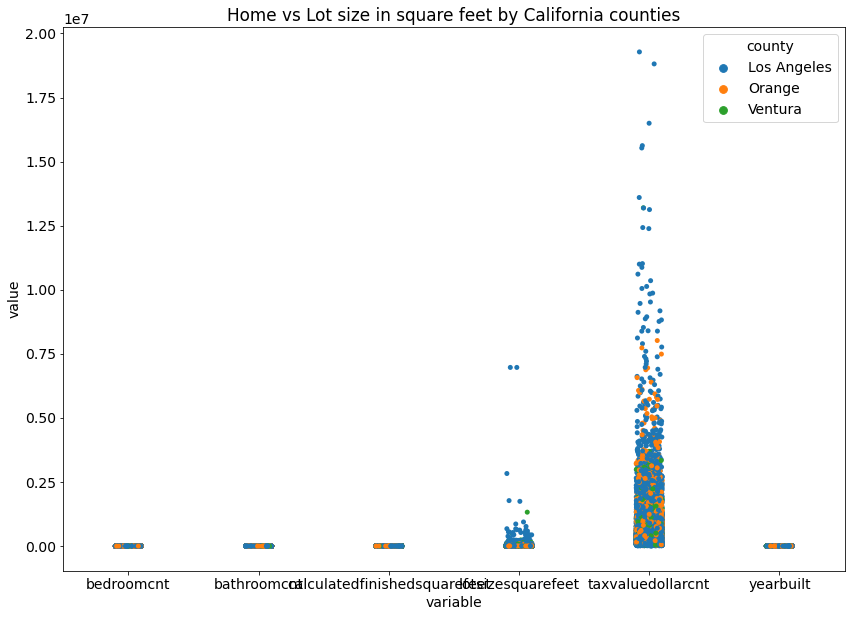

In [40]:
explore_train2 = train[['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'county']]

melted = explore_train.melt(id_vars=['county'])

sns.stripplot(data=melted, x='variable', y='value', hue='county')

plt.title('Home vs Lot size in square feet by California counties')

plt.show()

##### Stripplot Takeaways
- The bedroom counts look fairly consistent up through 7 bedrooms then become much more sporadic.
- The bathroom counts are also fairly consistent up through 7 but are somewhat split up among the half baths

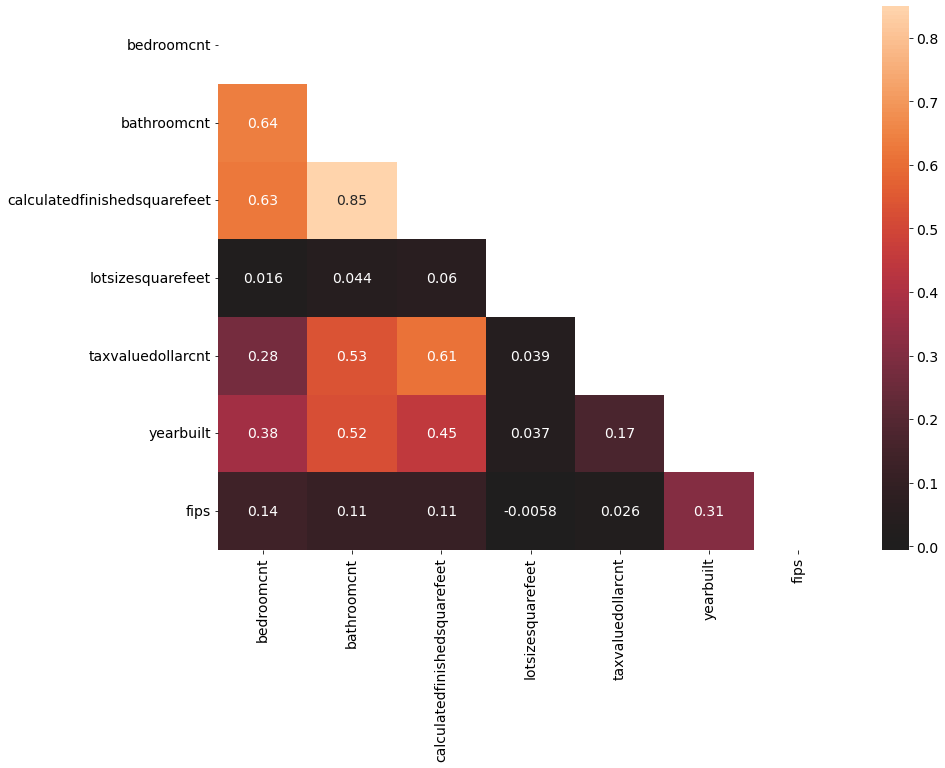

In [41]:
sns.heatmap(train.corr(), center=0, annot=True, mask=np.triu(train.corr()))

plt.title('')
plt.show()

##### Heatmap takeaways
- The strongest correlations are between the following:
    - The number of bathrooms and housing ft$^2$
    - The number of bedrooms with the number of bathrooms
    - The number of bedrooms and housing ft$^2$
    - The housing ft$^2$ and the tax value dollar count

Text(0.5, 1.0, 'Tax Value Dollar Count vs Lot Size ft$^2$')

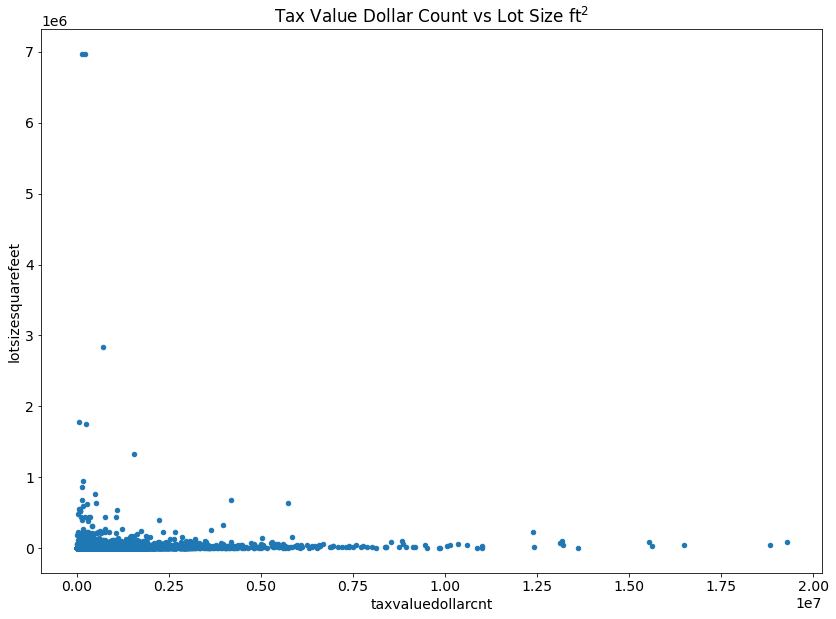

In [42]:
# visualizes distribution of correlation for tax value dollar count and lot size in a scatter plot
explore_train.plot.scatter('taxvaluedollarcnt', 'lotsizesquarefeet')
plt.title('Tax Value Dollar Count vs Lot Size ft$^2$')

Text(0.5, 1.0, 'Tax Value Dollar Count vs House Size in ft$^2$')

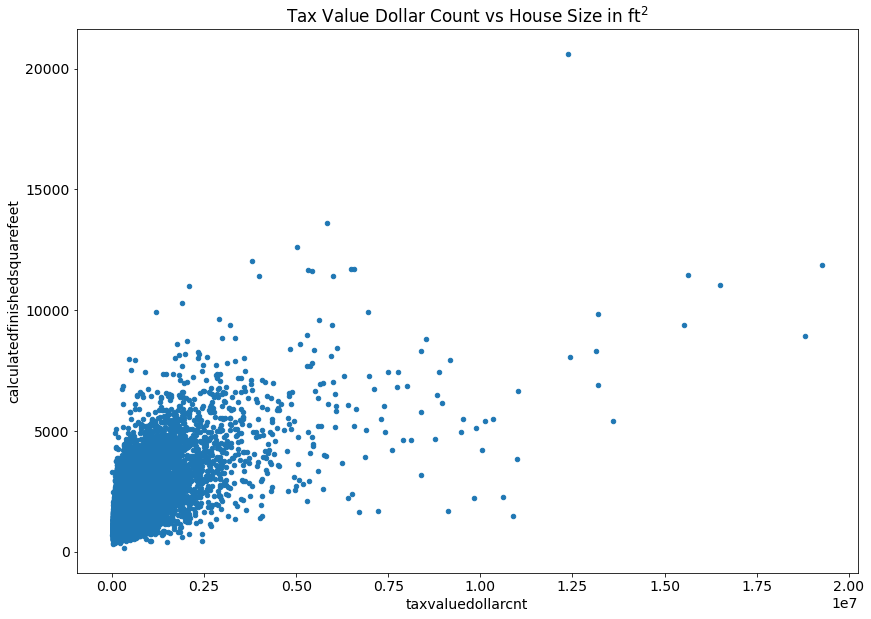

In [43]:
# visualizes distribution of correlation for tax value dollar count and lot size in a scatter plot
explore_train.plot.scatter('taxvaluedollarcnt', 'calculatedfinishedsquarefeet')
plt.title('Tax Value Dollar Count vs House Size in ft$^2$')

In [44]:
Q1 = explore_train.quantile(0.25)
Q3 = explore_train.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

bedroomcnt                           1.00
bathroomcnt                          1.00
calculatedfinishedsquarefeet      1025.25
lotsizesquarefeet                 3206.25
taxvaluedollarcnt               423005.50
yearbuilt                           29.00
dtype: float64


In [45]:
df_out = explore_train[~((explore_train < (Q1 - 1.5 * IQR)) |(explore_train > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df_out.shape)

(20504, 7)


(array([2.4235e+04, 5.3900e+02, 9.6000e+01, 3.3000e+01, 1.7000e+01,
        9.0000e+00, 5.0000e+00, 1.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([1.000000e+03, 1.928970e+06, 3.856940e+06, 5.784910e+06,
        7.712880e+06, 9.640850e+06, 1.156882e+07, 1.349679e+07,
        1.542476e+07, 1.735273e+07, 1.928070e+07]),
 <BarContainer object of 10 artists>)

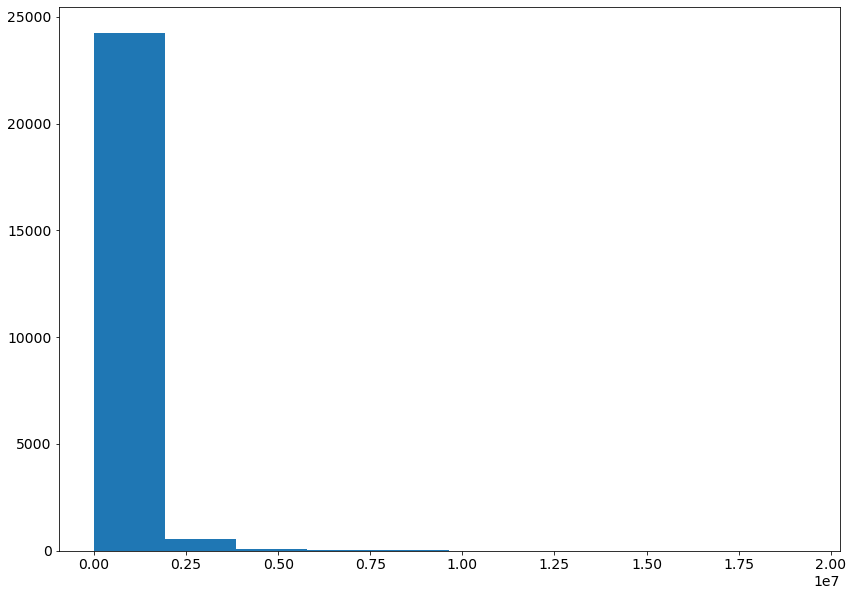

In [46]:
plt.hist(explore_train[['taxvaluedollarcnt']])

Normal Distribution assumption can be be met by having a large enough sample (due to Central Limit Theorem), or the data can be scaled using a Gaussian Scalar

In [47]:
taxes = explore_train.taxvaluedollarcnt

taxes.shape

(24940,)

<AxesSubplot:>

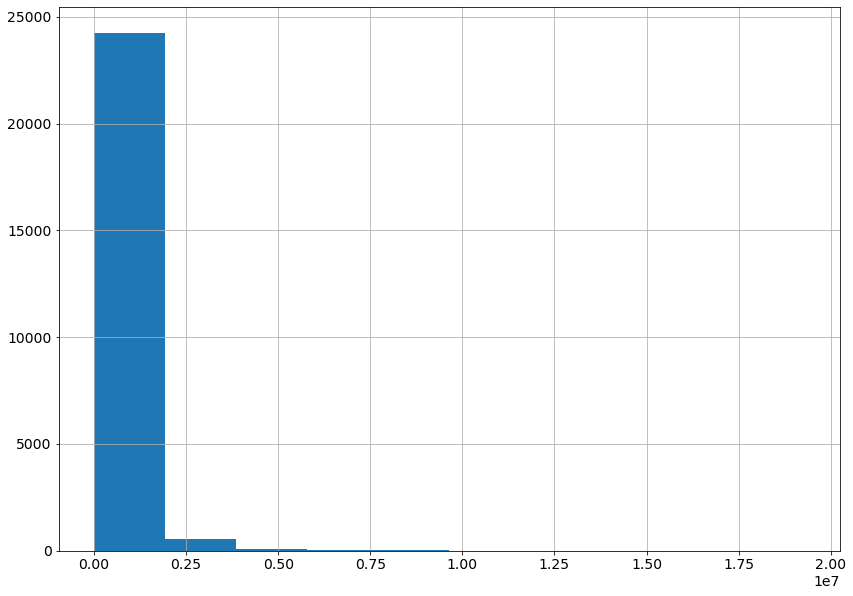

In [48]:
taxes.hist()

In [49]:
lot_size = explore_train.lotsizesquarefeet

lot_size.shape

(24940,)

<AxesSubplot:>

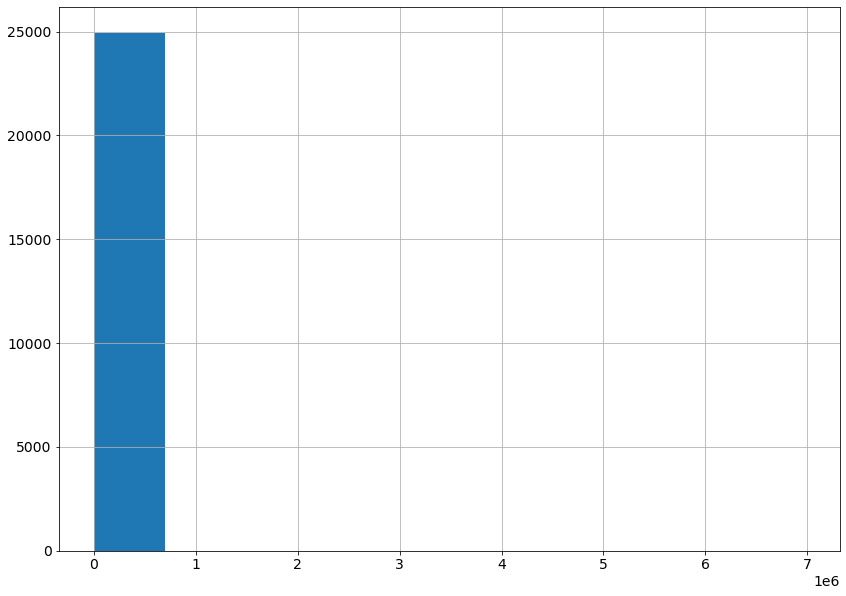

In [50]:
lot_size.hist()

In [51]:
t, p = stats.ttest_ind(taxes, lot_size, equal_var=False)
t, p / 2

(113.20535439342805, 0.0)

In [52]:
# 'if' statement to print out result of our null hypothesis
if p < alpha:
        print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Reject the null hypothesis


In [53]:
one_bath = explore_train[explore_train.bathroomcnt == 1].taxvaluedollarcnt
two_bed = explore_train[explore_train.bedroomcnt == 2].taxvaluedollarcnt


In [54]:
one_bath.shape

(4537,)

<AxesSubplot:>

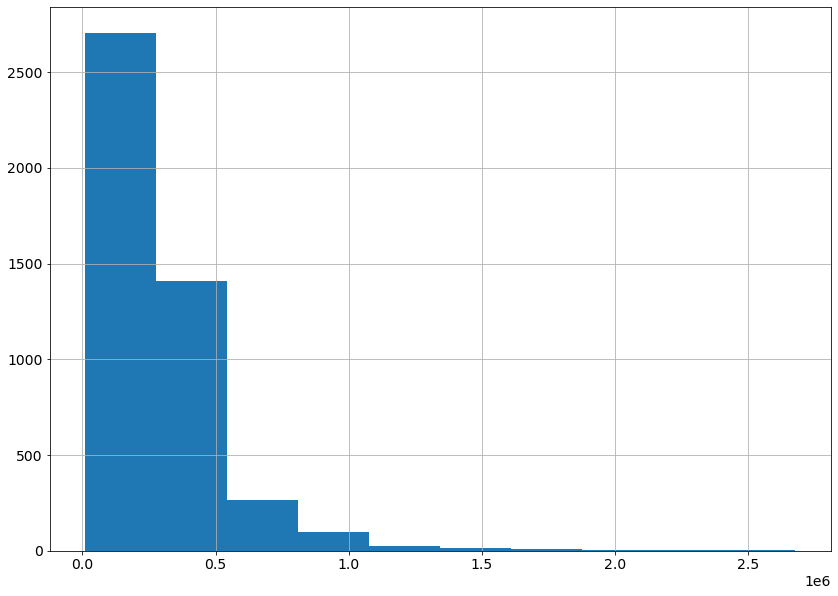

In [55]:
one_bath.hist()

In [56]:
two_bed.shape


(3995,)

<AxesSubplot:>

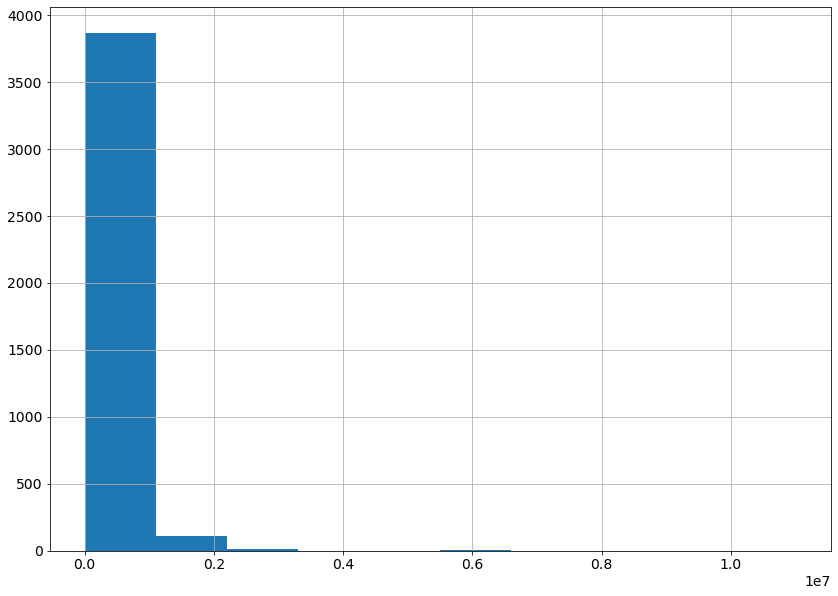

In [57]:
two_bed.hist()

In [58]:
t, p = stats.ttest_ind(one_bath, two_bed, equal_var=False)

t, p


(-10.206764964233807, 2.9004403964718822e-24)

In [59]:
# if statement to print out result of our null hypothesis
if p < alpha:
        print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Reject the null hypothesis


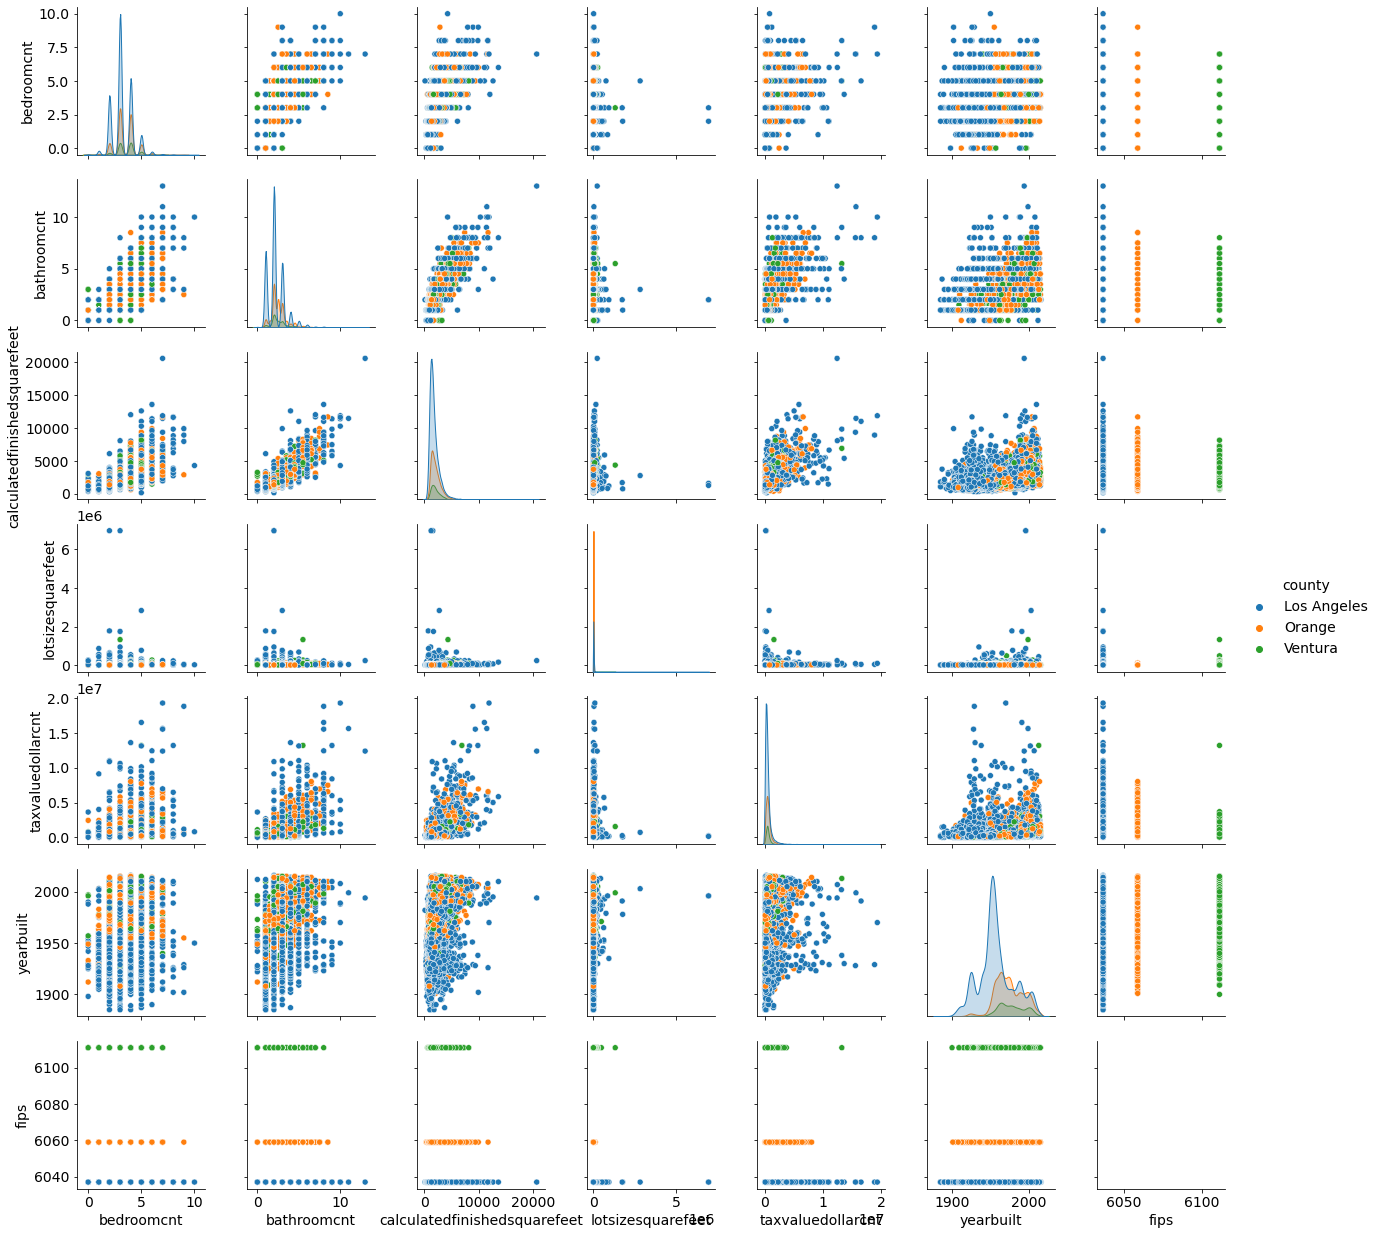

In [60]:
sns.pairplot(train, hue='county', corner=False)
plt.show()

### Scaling Data

In [61]:
import sklearn.preprocessing

In [62]:
train

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,lotsizesquarefeet,taxvaluedollarcnt,yearbuilt,fips,county
29975,3.0,2.0,1238.0,6969.0,237037.0,1954.0,6037.0,Los Angeles
22486,4.0,3.0,3833.0,9964.0,287413.0,2007.0,6037.0,Los Angeles
18433,4.0,2.0,1304.0,6000.0,66419.0,1959.0,6059.0,Orange
6445,4.0,2.0,1620.0,9992.0,157617.0,1957.0,6037.0,Los Angeles
17421,4.0,2.0,1963.0,11049.0,499310.0,1961.0,6037.0,Los Angeles
...,...,...,...,...,...,...,...,...
3076,3.0,2.0,1737.0,8901.0,407191.0,1968.0,6059.0,Orange
26764,3.0,2.0,1300.0,7745.0,268568.0,1954.0,6037.0,Los Angeles
22519,5.0,4.5,3728.0,3960.0,212968.0,1962.0,6059.0,Orange
9386,3.0,2.0,1337.0,6150.0,62699.0,1950.0,6037.0,Los Angeles


In [63]:
def scale_zillow(train, validate, test,
                 cols_to_scale = ['bedroomcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt']):
    '''
    Accepts train, validate, and test as inputs from split data then returns scaled versions for each one
    '''
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    scaler = sklearn.preprocessing.RobustScaler()

    scaler.fit(train[cols_to_scale])
    
    train_scaled[cols_to_scale] = pd.DataFrame(scaler.transform(train[cols_to_scale]), columns=train[cols_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[cols_to_scale] = pd.DataFrame(scaler.transform(validate[cols_to_scale]), columns=validate[cols_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[cols_to_scale] = pd.DataFrame(scaler.transform(test[cols_to_scale]), columns=test[cols_to_scale].columns.values).set_index([test.index.values])
    
    return train_scaled, validate_scaled, test_scaled

In [64]:
train_scaled, validate_scaled, test_scaled = scale_zillow(train, validate, test)

In [65]:
# splits our training set into x and y values to run in our algorithms
X_train_scaled = train_scaled.drop(columns=['taxvaluedollarcnt', 'county', 'yearbuilt', 'fips'])
y_train_scaled = train_scaled['taxvaluedollarcnt']

# splits our validate set into x and y values to run in our algorithms
X_validate_scaled = validate_scaled.drop(columns=['taxvaluedollarcnt', 'county', 'yearbuilt', 'fips'])
y_validate_scaled = validate_scaled['taxvaluedollarcnt']

# splits our test set into x and y values to run in our algorithms
X_test_scaled = test_scaled.drop(columns=['taxvaluedollarcnt', 'county', 'yearbuilt', 'fips'])
y_test_scaled = test_scaled['taxvaluedollarcnt']

In [67]:
y_train['yhat_baseline'] = y_train.mean()
y_train.head(3)


29975    237037.0
22486    287413.0
18433     66419.0
Name: taxvaluedollarcnt, dtype: float64

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=2)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train_scaled)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()


In [ ]:
f_feature

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=2)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train_scaled)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [ ]:
rfe_feature